# Guided Project: Practice Optimizing Dataframes and Processing in Chunks

In this guided project, we'll practice working with chunked dataframes and optimizing a dataframe's memory usage. We'll be working with financial lending data from Lending Club, a marketplace for personal loans that matches borrowers with investors. You can read more about the marketplace on its website.

The Lending Club's website lists approved loans. Qualified investors can view the borrower's credit score, the purpose of the loan, and other details in the loan applications. Once a lender is ready to back a loan, it selects the amount of money it wants to fund. When the loan amount the borrower requested is fully funded, the borrower receives the money, minus the origination fee that Lending Club charges.

We'll be working with a dataset of loans approved from 2007-2011, which you can download from Lending Club's website. We've already removed the desc column for you to make our system run more quickly.

If we read in the entire data set, it will consume about <b><i>66 megabytes of memory</b></i>. Let's imagine that we only have <b><i>10 megabytes of memory available throughout this project</i></b>, so you can practice the concepts you learned in the last two missions. You can find the solutions notebook for this guided project in our GitHub repo.

## Summary Of Final Results

Optimization allowed for the 66 megabytes of memory for the whole dataframe to be reduced to 15 megabytes. A <b>reduction of 77%</b> from the original size. Therefore, instead of reading in 14 chunks from the csv file for the unoptimized dataframe we would only have to read in 4 chunks. Please keep reading for more of the specifics of how the optimization.

The data file is <code>loans_2007.csv</code>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.options.display.max_columns = 99
%matplotlib inline

Will be reading in the few lines of the data and get a sense of the data.

In [2]:
loans = pd.read_csv("loans_2007.csv", low_memory=False).head()
loans

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,3.0,0.0,13648.0,83.7%,9.0,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-2015,171.62,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,3.0,0.0,1687.0,9.4%,4.0,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,2.0,0.0,2956.0,98.5%,10.0,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-2014,649.91,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,10.0,0.0,5598.0,21%,37.0,f,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-2015,357.48,Apr-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,15.0,0.0,27783.0,53.9%,38.0,f,461.73,461.73,3581.120000,3581.12,2538.27,1042.85,0.00,0.00,0.00,Jun-2016,67.79,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0


Read in the first 1000 rows from the data set, and calculate the total memory usage for these rows. Increase or decrease the number of rows to converge on a memory usage under five megabytes (to stay on the conservative side).

In [3]:
def chunksize_MB(csv_file,chunksize):
    """
    Takes csv file name and chunksize
    returns max chunksize in MB and number of chunks
    """
        
    chunk_iter = pd.read_csv(csv_file, chunksize=chunksize)

    memory_footprints = []

    for chunk in chunk_iter:
        memory_chunk = chunk.memory_usage(deep=True).sum() / 1048576 # Memory in MB
        memory_footprints.append(memory_chunk)
    
    return max(memory_footprints),len(memory_footprints)

In [4]:
file = "loans_2007.csv"
x = []
y = []

for chunksize in [x for x in range(500,5500,500)]:
    MB,num_chunks = chunksize_MB(file, chunksize)
    x.append(chunksize) 
    y.append(MB)

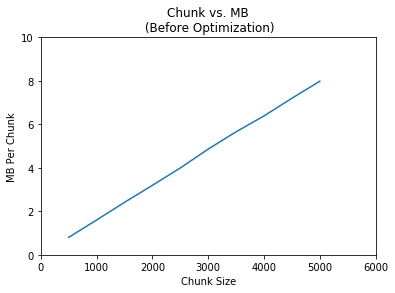

[500, 0.802891731262207]
[1000, 1.6007518768310547]
[1500, 2.4139976501464844]
[2000, 3.1956729888916016]
[2500, 3.9940929412841797]
[3000, 4.862635612487793]
[3500, 5.65931510925293]
[4000, 6.387155532836914]
[4500, 7.200401306152344]
[5000, 7.983414649963379]


In [5]:
plt.plot(x, y)
plt.title("Chunk vs. MB\n (Before Optimization)")
plt.ylabel("MB Per Chunk")
plt.xlabel("Chunk Size")
plt.axis([0,6000,0,10])
plt.show()

xy = []
for i, xi in enumerate(x):
    print([xi, y[i]])

So based on the graph above, it looks like <b>3000</b> is the max chunksize that can be used and stay below the 5 MB limit when there is no optimization involved with reading in the data.

3000 rows is the max chunksize that can be used before optimization. Now we will start looking at organizing data into more efficient memory stroage in the dataframe.

So for each chunk:
    - How many columns have a numeric type? How many have a string type?
    - How many unique values are there in each string column? How many of the string columns contain values that are less than 50% unique?
    - Which float columns have no missing values and could be candidates for conversion to the integer type?
    
## Float Column Conversions

First will start with if the columns read in as float values can be represented with a lower memory consuming type by using <code>downcast</code>.

In [6]:
# Load in chunked data
chunk_iter = pd.read_csv("loans_2007.csv", chunksize=3000)

# Counters
changed, unchanged, downcast_dict = 0, 0, {}

# Iter Over Each Chunk
for chunk in chunk_iter:
    # Select out float dtypes
    loans_float = chunk.select_dtypes(include=['float']).dtypes
    
    for col, col_type in loans_float.items():
        type_before = col_type
        chunk[col] = pd.to_numeric(chunk[col], downcast='float')
        type_after = chunk[col].dtypes

        # Count if changed type or not
        if type_before != type_after:
            changed += 1
        else:
            unchaged += 0
        
        # Add to Dict
        if col not in downcast_dict:
            # Create Col and inital chunk types
            downcast_dict[col] = {'before': set(), 'after': set()}
            downcast_dict[col]['before'].add(type_before)
            downcast_dict[col]['after'].add(type_after)
        else:
            downcast_dict[col]['before'].add(type_before)
            downcast_dict[col]['after'].add(type_after)

# Results Printed
print('Downcast Function Results')
print("{:25} {:d}".format('Total Changed columns:',changed))
print("{:25} {:d}".format('Total Unchanged columns:',unchanged))
print("{:30}{:20}{:20}".format('col name','type before','type after'))
for k, v in downcast_dict.items():
    print("{:30}{:20}{:20}".format(k, str(v['before']), str(v['after'])))

Downcast Function Results
Total Changed columns:    450
Total Unchanged columns:  0
col name                      type before         type after          
member_id                     {dtype('float64')}  {dtype('float32')}  
loan_amnt                     {dtype('float64')}  {dtype('float32')}  
funded_amnt                   {dtype('float64')}  {dtype('float32')}  
funded_amnt_inv               {dtype('float64')}  {dtype('float32')}  
installment                   {dtype('float64')}  {dtype('float32')}  
annual_inc                    {dtype('float64')}  {dtype('float32')}  
dti                           {dtype('float64')}  {dtype('float32')}  
delinq_2yrs                   {dtype('float64')}  {dtype('float32')}  
inq_last_6mths                {dtype('float64')}  {dtype('float32')}  
open_acc                      {dtype('float64')}  {dtype('float32')}  
pub_rec                       {dtype('float64')}  {dtype('float32')}  
revol_bal                     {dtype('float64')}  {dtype('float3

So using the downcast option, each time a float64 column was read in as a chunk it was downcast to float32 dataframe. Now lets look to see if any of the previous float columns can be converted to int types if they don't have any <code>null</code> values.

In [7]:
# Load in chunked data
chunk_iter = pd.read_csv("loans_2007.csv", chunksize=3000)

# counter for null values
col_null_count = {}

# Iter Over Each Chunk
for chunk in chunk_iter:
    # Select out float dtypes
    loans_float = chunk.select_dtypes(include=['float']).dtypes
    
    for col, col_type in loans_float.items():
        
        null_count = chunk[col].isnull().sum() # Count Null Values in Col
        
        if col in col_null_count:
            col_null_count[col] += int(null_count)
        else:
            col_null_count[col] = int(null_count)

# Results Printed
print('Null Values In Float Columns Results\n')
print("{:30}{:20}".format('Col Name','Number of Null Values'))
for k, v in col_null_count.items():
    print("{:30}{:20}".format(k, v))

Null Values In Float Columns Results

Col Name                      Number of Null Values
member_id                                        3
loan_amnt                                        3
funded_amnt                                      3
funded_amnt_inv                                  3
installment                                      3
annual_inc                                       7
dti                                              3
delinq_2yrs                                     32
inq_last_6mths                                  32
open_acc                                        32
pub_rec                                         32
revol_bal                                        3
total_acc                                       32
out_prncp                                        3
out_prncp_inv                                    3
total_pymnt                                      3
total_pymnt_inv                                  3
total_rec_prncp                            

In [8]:
# Rows with Just Three Missing Values
l = []
for k, v in col_null_count.items():
    if v == 3:
        l.append(k)

print(l)

['member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'dti', 'revol_bal', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'policy_code']


So based on the above results all float columns have null values. Lets look a little closer. The difficulty is that since the data is read in chunks, we have to select out all the chunks that have null values and make a seperate dataframe with those values include in it.

In [9]:
null_df = pd.DataFrame()
null_index = set()

# Load in chunked data
chunk_iter = pd.read_csv("loans_2007.csv", chunksize=3000)

# Iter Over Each Chunk
for chunk in chunk_iter:
    # Select out float dtypes
    loans_float_col = chunk.select_dtypes(include=['float']).columns
    
    # Loop over each column and find the index with missing data
    for col in loans_float_col:
        null = chunk[chunk[col].isnull()].index # Null Values in float cols
        
        # collect Every Null Index into null_index
        if null.size != 0:
            for index in null.tolist():
                null_index.add(index)
    
    # Add index to null_df
    for index in null_index:
        null_df[index] = chunk.loc[index]
    
    # Remove Index For Next Chunk
    null_index.clear()

# Transpose Values Because They Were Series During Selection in Chunk Loop
null_df = null_df.transpose()

Now we have a <code>null_df</code> with all the null values inlcuded in it. We will first look at the columns above that only have three NaN values.

In [10]:
# Columns with Three Missing Values
null_df[null_df['member_id'].isnull()]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
39786,Loans that do not meet the credit policy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42536,Total amount funded in policy code 1: 471701350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42537,Total amount funded in policy code 2: 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


So based on these rows <code>39786, 42536, 42537</code> these can safely be dicarded when being read since there is no real data in any of the columns. The advantage with this is that columns <code>['member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'dti', 'revol_bal', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'policy_code']</code> can all be read in as int values now since there is no NaN values in those columns now.

The way to achieve skipping specific indices on read is the <code>skiprows</code> parameter in <code>pd.read_csv</code>. The skiprows index values will need to be increased by one since there is a header in the csv.

In [11]:
# Load in chunked data
chunk_iter = pd.read_csv("loans_2007.csv", chunksize=3000, skiprows=[39787,42537,42538])

# counter for null values
col_null_count = {}

# Iter Over Each Chunk
for chunk in chunk_iter:
    # Select out float dtypes
    loans_float = chunk.select_dtypes(include=['float']).dtypes
    
    for col, col_type in loans_float.items():
        
        null_count = chunk[col].isnull().sum() # Count Null Values in Col
        
        if col in col_null_count:
            col_null_count[col] += int(null_count)
        else:
            col_null_count[col] = int(null_count)

# Results Printed
print('Null Values In Float Columns Results\n\
While Skipping [39787,42537,42538]\n')
print("{:30}{:20}".format('Col Name','Number of Null Values'))
for k, v in col_null_count.items():
    print("{:30}{:20}".format(k, v))

Null Values In Float Columns Results
While Skipping [39787,42537,42538]

Col Name                      Number of Null Values
member_id                                        0
loan_amnt                                        0
funded_amnt                                      0
funded_amnt_inv                                  0
installment                                      0
annual_inc                                       4
dti                                              0
delinq_2yrs                                     29
inq_last_6mths                                  29
open_acc                                        29
pub_rec                                         29
revol_bal                                        0
total_acc                                       29
out_prncp                                        0
out_prncp_inv                                    0
total_pymnt                                      0
total_pymnt_inv                                  0
total_re

As can be seen above, the null values that were holding up the conversion for float to int have been removed for a large majority of the columns with the dropping of specified rows.

## Object Type Conversions

Now we will look at the object datatypes and see if any of the values in those columns can be set to more optimized data types.

In [12]:
# Load in chunked data
chunk_iter = pd.read_csv("loans_2007.csv", chunksize=3000)

for chunk in chunk_iter:
    # Select out object dtypes
    loans_obj = chunk.select_dtypes(include=['object'])
    
    show = loans_obj.head()
    
    break

show

,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,earliest_cr_line,revol_util,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type
0,36 months,10.65%,B,B2,NaN,10+ years,RENT,Verified,Dec-2011,Fully Paid,n,credit_card,Computer,860xx,AZ,Jan-1985,83.7%,f,Jan-2015,Jun-2016,INDIVIDUAL
1,60 months,15.27%,C,C4,Ryder,< 1 year,RENT,Source Verified,Dec-2011,Charged Off,n,car,bike,309xx,GA,Apr-1999,9.4%,f,Apr-2013,Sep-2013,INDIVIDUAL
2,36 months,15.96%,C,C5,NaN,10+ years,RENT,Not Verified,Dec-2011,Fully Paid,n,small_business,real estate business,606xx,IL,Nov-2001,98.5%,f,Jun-2014,Jun-2016,INDIVIDUAL
3,36 months,13.49%,C,C1,AIR RESOURCES BOARD,10+ years,RENT,Source Verified,Dec-2011,Fully Paid,n,other,personel,917xx,CA,Feb-1996,21%,f,Jan-2015,Apr-2016,INDIVIDUAL
4,60 months,12.69%,B,B5,University Medical Group,1 year,RENT,Source Verified,Dec-2011,Current,n,other,Personal,972xx,OR,Jan-1996,53.9%,f,Jun-2016,Jun-2016,INDIVIDUAL


Taking a look at the object datatypes read in a few columns show that they can be read in as certain types on read that can help with the optimization of the memory foot print of the dataframe.

|Column|Opt Type|notes|
|:---:|:---:|:--:|
|term|category||
|int_rate|float|remove % and keep float value|
|grade|category||
|emp_title|category||
|sub_grade|category||
|emp_length|category||
|home_ownership|category||
|verification_status|category||
|loan_status|category||
|pymnt_plan|category||
|purpose|category||
|title|category||
|zip_code|category||
|addr_state|category||
|revol_util|float|remove % sign and keep float value|
|inital_list_status|category||
|application_type|category||

Want to varify that the catigories list above would save memory when used as a category type. This is the case as long as less than 50% of the values are unique in the column. So to varify this, we will pull in each column individually and compute some statistics.

In [13]:
possible_cat_cols = ['term','grade','sub_grade','emp_title','emp_length','home_ownership',
                     'verification_status','loan_status','pymnt_plan',
                     'purpose','title','zip_code','addr_state',
                     'initial_list_status','application_type']

stats = [['col_name','length','unique','length_null_values',
         'per_unique','memory_MB','memory_MB_cat','reduction']]

for col in possible_cat_cols:
    col_df = pd.read_csv("loans_2007.csv", usecols=[col])
    
    # Calculated Stats
    memory_MB = col_df.memory_usage(deep=True).sum() / 1048576 # Memory in MB
    length = len(col_df.index)
    unique = len(col_df[col].value_counts(dropna=False))
    length_null_values = len(col_df[col_df[col].isnull()].index)
    per_unique = unique / length
    
    # Reduction in Memory for category type
    col_df[col] = col_df[col].astype('category')
    memory_MB_cat = col_df.memory_usage(deep=True).sum() / 1048576 # Memory in MB
    reduction = (memory_MB - memory_MB_cat) / memory_MB
    
    stats.append([col,length,unique,length_null_values,round(per_unique,3),
                  round(memory_MB,4),round(memory_MB_cat,4),round(reduction,2)])

stats = pd.DataFrame(stats[1:],columns=stats[0])
stats

,col_name,length,unique,length_null_values,per_unique,memory_MB,memory_MB_cat,reduction
0,term,42538,3,3,0.000,2.7180,0.0409,0.98
1,grade,42538,8,3,0.000,2.5152,0.0414,0.98
2,sub_grade,42538,36,3,0.001,2.3935,0.0439,0.98
3,emp_title,42538,30659,2629,0.721,2.9481,3.5643,-0.21
4,emp_length,42538,12,1115,0.000,2.5817,0.0417,0.98
5,home_ownership,42538,6,3,0.000,2.5440,0.0411,0.98
6,verification_status,42538,4,3,0.000,2.7773,0.0410,0.99
7,loan_status,42538,10,3,0.000,2.8266,0.0417,0.99
8,pymnt_plan,42538,3,3,0.000,2.5152,0.0409,0.98
9,purpose,42538,15,3,0.000,2.8678,0.0422,0.99


So the only columns that would not benefit from a category column types is the title column since 50% of the values were unique and there was only a reduction in memory of 25% and the emp_title column which resulted in an increase in memory since 72% of the values were unique.

### Removing Text From Object and Converting to Float

We can see in the <code>int_rate</code> and <code>revol_util</code> columns that the only thing keeping them from being converted to a float value is the inclusion of the <i>"%"</i> symbol in the columns. We can remove those with the help of a custom conversion function during <code>pd.read_csv</code>. 

In [14]:
def convert_percent(val):
    """
    Convert the string number value to a float
     - Remove %
     - Remove commas
     - Convert to float type 
    """
    
    if val != '':
        new_val = val.strip().replace(',','').replace('%', '')
        return np.float32(new_val)
    else:
        return val

possible_float_cols = ['int_rate','revol_util']

stats = [['col_name','length','length_null_values',
         'memory_MB','memory_MB_opt','reduction']]

for col in possible_float_cols:
    col_df = pd.read_csv("loans_2007.csv", usecols=[col])
    col_df_optimized = pd.read_csv("loans_2007.csv", usecols=[col], converters={col: convert_percent})
    
    # Calculated Stats
    memory_MB = col_df.memory_usage(deep=True).sum() / 1048576 # Memory in MB
    length = len(col_df.index)
    length_null_values = len(col_df[col_df[col].isnull()].index)
    
    # Reduction in Memory for category type
    memory_MB_opt = col_df_optimized.memory_usage(deep=True).sum() / 1048576 # Memory in MB
    reduction = (memory_MB - memory_MB_opt) / memory_MB
    
    stats.append([col,length,length_null_values,
                  round(memory_MB,4),round(memory_MB_opt,4),round(reduction,2)])

stats = pd.DataFrame(stats[1:],columns=stats[0])
stats

C:\Users\clayt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,col_name,length,length_null_values,memory_MB,memory_MB_opt,reduction
0,int_rate,42538,3,2.5963,1.3356,0.49
1,revol_util,42538,93,2.4983,1.4626,0.41


## Datetime Columns

Now we will look at the columns that have dates and see if those can be optimized for memory storage. We do a similar test as above and pull in each columns and compare the memory before and after the optimization for type.

|Column|Opt Type|notes|
|:---:|:---:|:--:|
|issue_d|datetime64|month-year|
|earliest_cr_line|datetime64|month-year|
|last_pymnt_d|datetime64|month-year|
|last_credit_pull_d|datetime64|month-year|

In [15]:
possible_datetime_col = ['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d']

stats = [['col_name','length','length_null_values','memory_MB','memory_MB_datetime','reduction']]

for col in possible_datetime_col:
    col_df = pd.read_csv("loans_2007.csv", usecols=[col])
    
    # Calculated Stats
    memory_MB = col_df.memory_usage(deep=True).sum() / 1048576 # Memory in MB
    length = len(col_df.index)
    length_null_values = len(col_df[col_df[col].isnull()].index)
    
    # Reduction in Memory for datetime type
    col_df[col] = col_df[col].astype('datetime64')
    memory_MB_datetime = col_df.memory_usage(deep=True).sum() / 1048576 # Memory in MB
    reduction = (memory_MB - memory_MB_datetime) / memory_MB
    
    stats.append([col,length,length_null_values,
                  round(memory_MB,4),round(memory_MB_datetime,4),round(reduction,2)])

stats = pd.DataFrame(stats[1:],columns=stats[0])
stats

,col_name,length,length_null_values,memory_MB,memory_MB_datetime,reduction
0,issue_d,42538,3,2.6369,0.3247,0.88
1,earliest_cr_line,42538,32,2.6360,0.3247,0.88
2,last_pymnt_d,42538,86,2.6343,0.3247,0.88
3,last_credit_pull_d,42538,7,2.6368,0.3247,0.88


So looking at the output data above we can see that using the <code>datetime64</code> dtype can result in a memory rudction of 88%.

## Comparing Optimized and Non-Optimized Panda Chunk Memory Sizes

So we will combine all the useful information from optimizing the data types and see how the memory was reduced per chunk now that we have optimize the data types being pulled in. First we need to create a dictonary of all the columns names as the key and the NumPy types objects as the values.

In [16]:
# Setup inital dict with all columns names and default None
col_dtype_dict = {}
for x in pd.read_csv("loans_2007.csv", low_memory=False).head(0).columns.tolist():
    col_dtype_dict[x] = None

# Remove datetime values since they will be set with parse_dates
for key in ['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d']:
    col_dtype_dict.pop(key)

# Remove values that use converter
for key in ['int_rate','revol_util']:
    col_dtype_dict.pop(key)

# Setup dict with types mapped to columns
col_dtype_dict['id'] = np.float32
col_dtype_dict['member_id'] = np.float32
col_dtype_dict['loan_amnt'] = np.float32
col_dtype_dict['funded_amnt'] = np.float32
col_dtype_dict['funded_amnt_inv'] = np.float32
col_dtype_dict['term'] = 'category'
col_dtype_dict['installment'] = np.float32
col_dtype_dict['grade'] = 'category'
col_dtype_dict['sub_grade'] = 'category'
col_dtype_dict['emp_title'] = 'object'
col_dtype_dict['emp_length'] = 'category'
col_dtype_dict['home_ownership'] = 'category'
col_dtype_dict['annual_inc'] = np.float32
col_dtype_dict['verification_status'] = 'category'
col_dtype_dict['loan_status'] = 'category'
col_dtype_dict['pymnt_plan'] = 'category'
col_dtype_dict['purpose'] = 'category'
col_dtype_dict['title'] = 'object'
col_dtype_dict['zip_code'] = 'category'
col_dtype_dict['addr_state'] = 'category'
col_dtype_dict['dti'] = np.float32
col_dtype_dict['delinq_2yrs'] = np.float32
col_dtype_dict['inq_last_6mths'] = np.float32
col_dtype_dict['open_acc'] = np.float32
col_dtype_dict['pub_rec'] = np.float32
col_dtype_dict['revol_bal'] = np.float32
col_dtype_dict['total_acc'] = np.float32
col_dtype_dict['initial_list_status'] = 'category'
col_dtype_dict['out_prncp'] = np.float32
col_dtype_dict['out_prncp_inv'] = np.float32
col_dtype_dict['total_pymnt'] = np.float32
col_dtype_dict['total_pymnt_inv'] = np.float32
col_dtype_dict['total_rec_prncp'] = np.float32
col_dtype_dict['total_rec_int'] = np.float32
col_dtype_dict['total_rec_late_fee'] = np.float32
col_dtype_dict['recoveries'] = np.float32
col_dtype_dict['collection_recovery_fee'] = np.float32
col_dtype_dict['last_pymnt_amnt'] = np.float32
col_dtype_dict['collections_12_mths_ex_med'] = np.float32
col_dtype_dict['policy_code'] = np.float32
col_dtype_dict['application_type'] = 'category'
col_dtype_dict['acc_now_delinq'] = np.float32
col_dtype_dict['chargeoff_within_12_mths'] = np.float32
col_dtype_dict['delinq_amnt'] = np.float32
col_dtype_dict['pub_rec_bankruptcies'] = np.float32
col_dtype_dict['tax_liens'] = np.float32

# Check that all columns have been set
if None in col_dtype_dict.values():
    print('Not All Values Set')
else:
    print('All Column Values Set')

All Column Values Set


## Final Results

In [17]:
converters_dict = {'int_rate': convert_percent,'revol_util': convert_percent}
skip_rows = [39787,42537,42538]
datetime_col = ['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d']
chunksize=3000

memory_footprints = [['type_df','chunksize','column_types','memory_chunk_max_MB','total_memory_MB']]

# Optimized Chunks
# Create Chunk Iter
chunk_iter = pd.read_csv("loans_2007.csv",
                         chunksize=chunksize,
                         dtype=col_dtype_dict,
                         converters=converters_dict,
                         skiprows=skip_rows,
                         parse_dates=datetime_col)
memory_footprint_total_MB = 0
memory_footprint_chunk = []
# Loop through chunks
for chunk in chunk_iter:
    memory_chunk = chunk.memory_usage(deep=True).sum() / 1048576 # Memory in MB
    memory_footprint_total_MB += memory_chunk
    memory_footprint_chunk.append(memory_chunk)
    chunk_types = chunk.dtypes.tolist()
# Add Info
memory_footprints.append(['Optimized',chunksize,chunk_types,max(memory_footprint_chunk),memory_footprint_total_MB])

# Chunks NO OPTIMIZATION
# Create Chunk Iter
chunk_iter = pd.read_csv("loans_2007.csv",
                         chunksize=chunksize)
memory_footprint_total_MB = 0
memory_footprint_chunk = []
# Loop through chunks
for chunk in chunk_iter:
    memory_chunk = chunk.memory_usage(deep=True).sum() / 1048576 # Memory in MB
    memory_footprint_total_MB += memory_chunk
    memory_footprint_chunk.append(memory_chunk)
    chunk_types = chunk.dtypes.tolist()
# Add Info
memory_footprints.append(['Not Optimized',chunksize,chunk_types,max(memory_footprint_chunk),memory_footprint_total_MB])

# Create Stats Data Frame
stats = pd.DataFrame(memory_footprints[1:],columns=memory_footprints[0])

print("Final Results:\nOptimized Data Frame had a {:.0f}% reduction in memory size".format(
    ((stats.loc[1]['total_memory_MB'] - stats.loc[0]['total_memory_MB']) / stats.loc[1]['total_memory_MB'])*100))

stats

Final Results:
Optimized Data Frame had a 77% reduction in memory size


,type_df,chunksize,column_types,memory_chunk_max_MB,total_memory_MB
0,Optimized,3000,"[float32, float32, float32, float32, float32, ...",1.113454,15.341172
1,Not Optimized,3000,"[object, float64, float64, float64, float64, o...",4.862636,65.729285
